In [16]:
import os
import pandas as pd
import re

# Function to find the last line with FID and IS scores
def find_last_matching_line(file_path, pattern):
    try:
        with open(file_path, 'rb') as f:
            # Go to the end of the file
            f.seek(0, os.SEEK_END)
            file_size = f.tell()
            
            # Start from the end of the file and move backwards
            for i in range(file_size, 0, -1):
                f.seek(i)
                # Try to read a line
                try:
                    line = f.readline().decode().strip()
                except UnicodeDecodeError:
                    continue  # Skip lines that can't be decoded
                
                # If the line matches the pattern, return it
                if re.search(pattern, line):
                    return line
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    
    # Return None if no matching line is found
    return None

# Function to find directories containing the specified keyword
def find_directories_with_keyword(directory, keyword):
    matching_directories = []  # List to hold all matching directory paths
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if keyword in dir_name:  # Check if the keyword is in the directory name
                matching_directory = os.path.join(root, dir_name)
                matching_directories.append(matching_directory)
    return matching_directories

# Function to list all files within given directories
def list_files_in_directories(directories):
    all_files = set()  # Use a set to avoid duplicates
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file_name in files:
                if file_name.endswith('.log'):
                    file_path = os.path.join(root, file_name)
                    all_files.add(file_path.lower())  # Adding with lower() to avoid case sensitivity issues
    return list(all_files)

def exp_namefromfile(file):
    parts = file.split('\\')
    exp_name = parts[-3]
    pattern = r"(.*?)_\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}"
    # Search for the pattern and extract the group
    match = re.search(pattern, exp_name)
    if match:
        desired_part = match.group(1)  # The first capturing group matches your target
        return(desired_part.split('_'))
    else:
        return("Pattern not found")


# Base directory containing potential subfolders
base_directory = 'exps\compress_rank'
# Keyword to search for in directory names
keyword = ''

# Find directories containing the keyword
directories = find_directories_with_keyword(base_directory, keyword)
# print(len(directories))

# List all files within those directories
log_files = list_files_in_directories(directories)
print(len(log_files))

# List to store the results
results = []
# Regular expression to match FID and IS scores
regex = r"FID score: ([\d\.]+)"
regex_cr = r"Layer Reduction ratio: (\d+\.\d+)"


# Process each file
for file in log_files:
    last_line = find_last_matching_line(file, regex)
    last_line_cr = find_last_matching_line(file, regex_cr)
    exp_name = exp_namefromfile(file)
    if last_line:  # Check if last_line is not None
        results.append([exp_name[0],exp_name[1],last_line,last_line_cr])
print(results)

# Specify the text file path
text_file_path = os.path.join(base_directory,'scores_data.txt')

# Write the data to the text file
with open(text_file_path, 'w') as file:
    for entry in results:
        file.write(f"{entry}\n")

# Return the path to the text file for download or further actions
text_file_path

70
[['256', '10', 'FID score: 5.140046954859599 || after compression.', 'Layer Reduction ratio: 77.48373101952278'], ['768', '6', 'FID score: 5.043809034594858 || after compression.', 'Layer Reduction ratio: 32.53796095444685'], ['768', '13', 'FID score: 5.552002704029974 || after compression.', 'Layer Reduction ratio: 75.51945008592408'], ['128', '4', 'FID score: 4.9581878995004445 || after compression.', 'Layer Reduction ratio: 95.90688954850805'], ['768', '4', 'FID score: 4.9841060330495 || after compression.', 'Layer Reduction ratio: 75.51945008592408'], ['256', '12', 'FID score: 5.177744918487292 || after compression.', 'Layer Reduction ratio: 91.82940165599125'], ['768', '9', 'FID score: 5.23692572908152 || after compression.', 'Layer Reduction ratio: 75.51945008592408'], ['4', 'l3', 'FID score: 5.051839898906053 || after compression.', 'Layer Reduction ratio: 87.79892339939023'], ['512', '8', 'FID score: 5.1254627159778465 || after compression.', 'Layer Reduction ratio: 55.01084

'exps\\compress_rank\\scores_data.txt'

In [17]:
# Import necessary libraries
import pandas as pd
import ast
import os 

# Path to the uploaded text file
file_path = os.path.join(base_directory,'scores_data.txt')

# Initialize a list to hold the data from the file
data = []

# Read the data from the text file
with open(file_path, 'r') as file:
    for line in file:
        # Convert string representation of list to actual list
        data.append(ast.literal_eval(line.strip()))

# Convert data into a DataFrame
df = pd.DataFrame(data, columns=['Rank', 'Layers', 'Details_FID','Details_CR'])

# Split the 'Details' column into three new columns: 'FID score', 'IS score', 'Epoch'
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')
df[['FID score']] = df['Details_FID'].str.extract(r'FID score: ([\d\.]+)').astype(float).round(2)
df[['Compression Ratio']] = df['Details_CR'].str.extract(r'Layer Reduction ratio: ([\d\.]+)').astype(float).round(2)
df['Compression Ratio'].fillna(0, inplace=True)

# Drop the 'Details' column as it's no longer needed
df = df.drop('Details_FID', axis=1)
df = df.drop('Details_CR', axis=1)

df['Rank'] = pd.to_numeric(df['Rank'])
df['Layers_sort'] = df['Layers'].apply(lambda x: int(x) if x.isdigit() else 999)
df_sorted = df.sort_values(by=['Rank', 'Layers_sort'])
df_sorted = df_sorted.drop(columns=['Layers_sort'])
df_sorted.reset_index(drop=True, inplace=True)
print(df_sorted)

# Specify the path for the new Excel file
excel_file_path = os.path.join(base_directory,'sorted_scores.xlsx')

# Write the sorted DataFrame to an Excel file
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    df_sorted.to_excel(writer, index=False, sheet_name='Sorted Scores')


    Rank Layers  FID score  Compression Ratio
0      2     l2       5.01              92.67
1      2     l1     126.79              92.64
2      2     l3       5.06              92.68
3      4     l3       5.05              87.80
4      4     l2       5.05              87.78
..   ...    ...        ...                ...
65   768      9       5.24              75.52
66   768     10       5.09              32.54
67   768     11       5.00              75.52
68   768     12       5.05              75.52
69   768     13       5.55              75.52

[70 rows x 4 columns]


C:\Users\pp4405\AppData\Local\Temp\ipykernel_26888\3985741626.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Compression Ratio'].fillna(0, inplace=True)


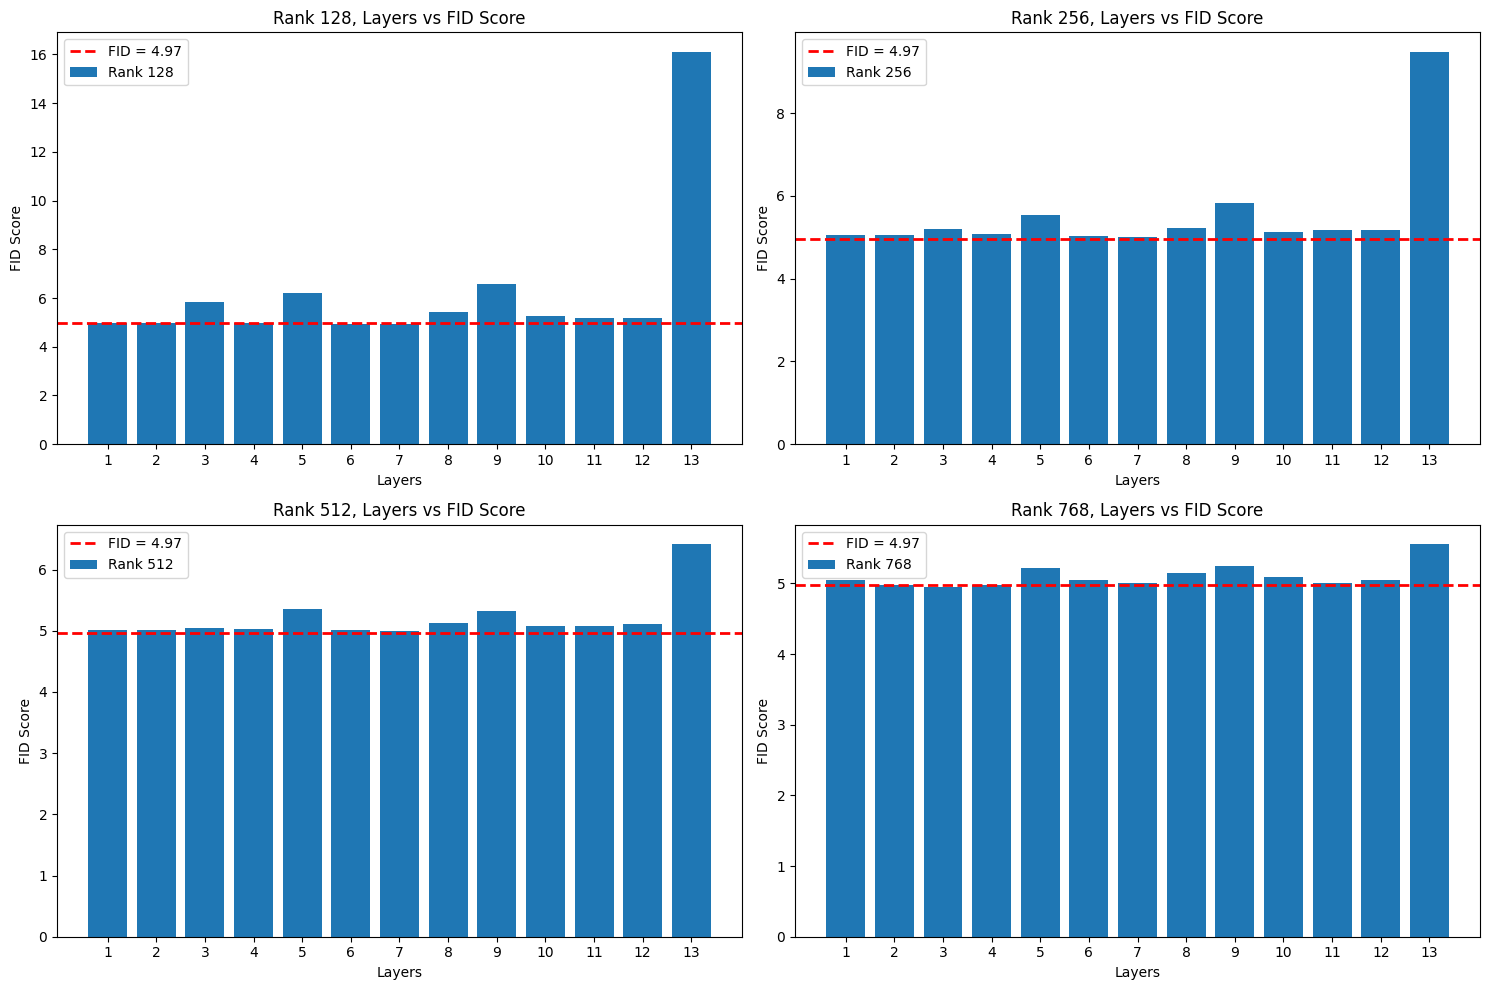

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Unique ranks in the DataFrame
df_sorted_plot = df_sorted
unique_ranks = df_sorted_plot['Rank'].unique()
df_sorted_plot['FID score'] = df_sorted_plot['FID score'].apply(lambda x: min(x, 30) if x > 30 else x)

# Setting up the figure for plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for i, rank in enumerate(sorted(unique_ranks)[6:10]):  # Limiting to first 4 unique ranks for this example
    # Filter the DataFrame for the current rank
    
    rank_df = df_sorted_plot[df_sorted_plot['Rank'] == rank]
    
    # Sorting values by 'Layers' might not be necessary if df_sorted is already sorted by 'Layers',
    # but ensure that 'Layers' including 'all' are handled if you haven't sorted them previously
    # rank_df = rank_df.sort_values(by='Layers')  # This line is optional based on your sorting logic
    
    # Plotting
    axes[i].bar(rank_df['Layers'], rank_df['FID score'], label=f'Rank {rank}')
    axes[i].set_title(f'Rank {rank}, Layers vs FID Score')
    axes[i].set_xlabel('Layers')
    axes[i].set_ylabel('FID Score')
    axes[i].axhline(y=4.97, color='r', linestyle='--', linewidth=2, label='FID = 4.97')
    axes[i].legend()

plt.tight_layout()
plt.show()


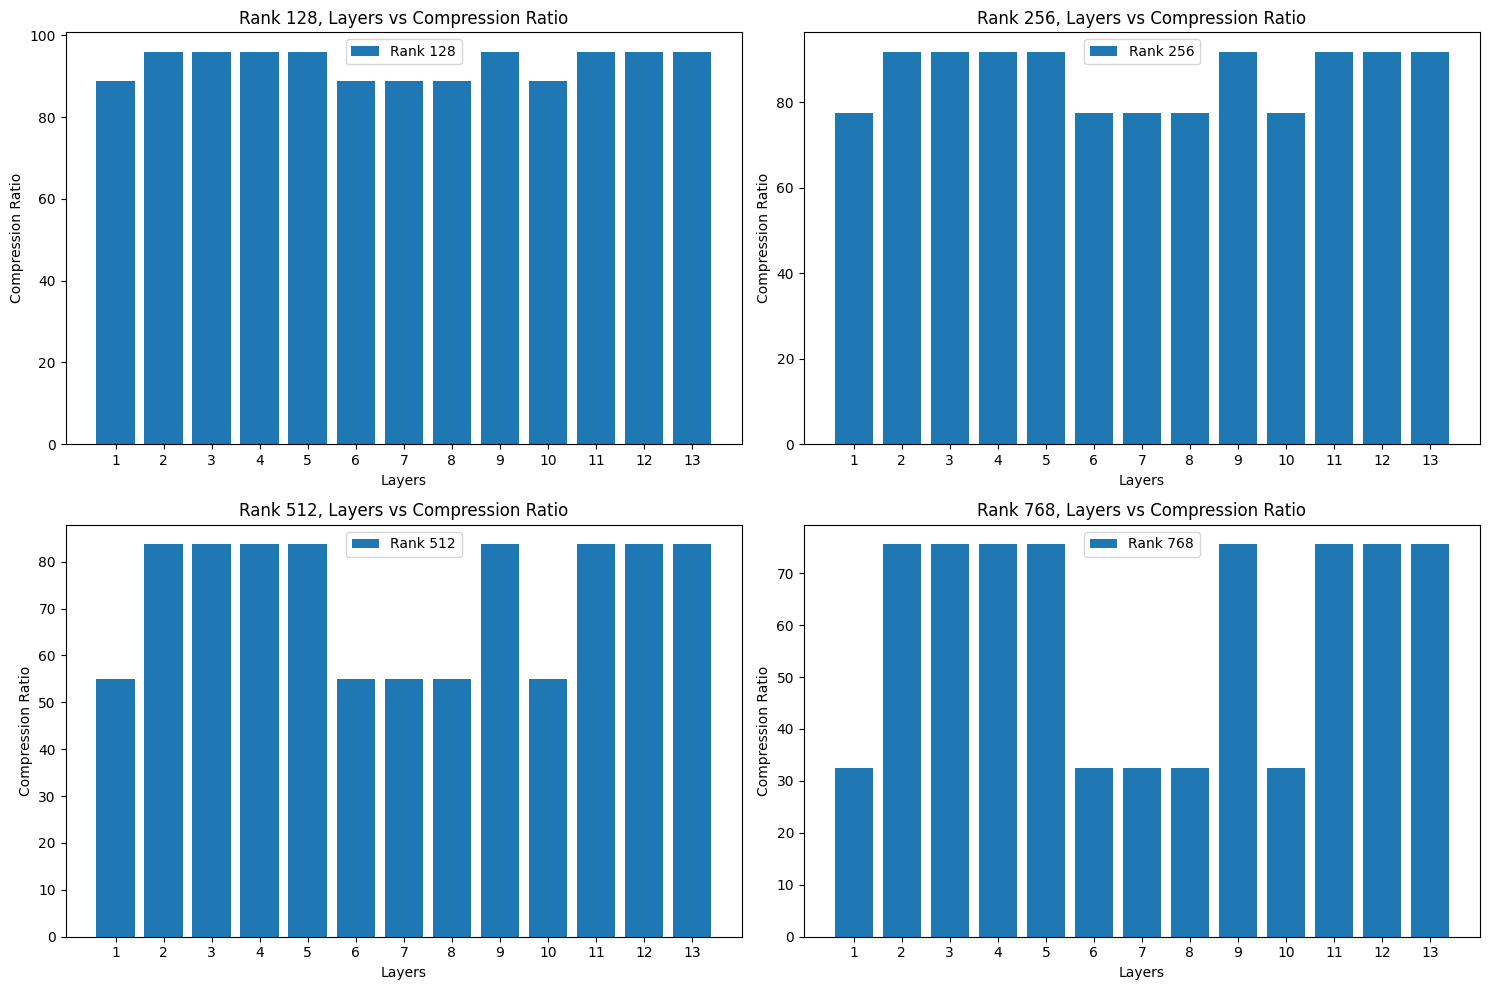

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Unique ranks in the DataFrame
df_sorted_plot = df_sorted
unique_ranks = df_sorted_plot['Rank'].unique()

# Setting up the figure for plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Iterate over each rank and its corresponding data
for i, rank in enumerate(sorted(unique_ranks)[6:10]):
    rank_df = df_sorted_plot[df_sorted_plot['Rank'] == rank]
        
    # Plotting
    axes[i].bar(rank_df['Layers'], rank_df['Compression Ratio'], label=f'Rank {rank}')
    axes[i].set_title(f'Rank {rank}, Layers vs Compression Ratio')
    axes[i].set_xlabel('Layers')
    axes[i].set_ylabel('Compression Ratio')
    axes[i].legend()

    # axes[i].grid(True)  # Turn on the grid

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd

# Load the Excel file
df = pd.read_excel(os.path.join(base_directory,'sorted_scores.xlsx'))

# Set the penalty rate
PenaltyRate = 1/20

# Calculate Rank_Penalty*fid_score and add it as a new column
df['Rank_Penalty x FID'] = df.apply(lambda row: (1 + (PenaltyRate * (1 - row['Compression Ratio'] / 100))) * row['FID score'], axis=1)

# Save the modified DataFrame back to an Excel file
df.to_excel(os.path.join(base_directory,'sorted_scores_with_penalty.xlsx'), index=False)

# Pivoting the DataFrame to have 'Rank' values as columns
pivot_df = df.pivot(index='Layers', columns='Rank', values=['FID score','Rank_Penalty x FID'])
pivot_df.columns = [f'Rank: {col}' for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

pivot_df['Layers_sort'] = pivot_df['Layers'].apply(lambda x: int(x) if x.isdigit() else 999)
pivot_df = pivot_df.sort_values(by=['Layers_sort'])
pivot_df = pivot_df.drop(columns=['Layers_sort'])

pivot_df['nc'] = (1 + PenaltyRate) * 4.97

# Save the modified DataFrame back to an Excel file
pivot_df.to_excel(os.path.join(base_directory,'pivot.xlsx'), index=False)

# Load the Excel file
df = pd.read_excel(os.path.join(base_directory,'pivot.xlsx'))

# Assuming the first column is 'Layers' and the rest are ranks
# Create a dictionary to hold the lowest rank for each layer
lowest_rank_per_layer = {}

# Iterate over each row to find the lowest FID score's rank
for index, row in df.iterrows():
    # Extract the layer number
    layer = row['Layers']
    # Find the column name (which is the rank) of the minimum FID score for the row
    lowest_rank = row.iloc[11:].idxmin()  # Excluding the first column which is 'Layers'
    # Add the layer and corresponding lowest rank to the dictionary
    lowest_rank_per_layer[layer] = lowest_rank

# Convert the dictionary to a DataFrame for better visualization or further processing
lowest_rank_df = pd.DataFrame(list(lowest_rank_per_layer.items()), columns=['Layers', 'Rank with Lowest FID'])

rank_numbers = [
    int(rank.split(',')[1].strip(') ').strip('\'')) if 'Rank' in rank else 'nc'
    for rank in lowest_rank_df['Rank with Lowest FID']
]
# Output the result
print(PenaltyRate)
print(df['Layers'].unique())
print(rank_numbers)


0.05
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 768, 128, 'nc', 128, 128, 'nc', 'nc', 512, 768, 768, 'nc', 'nc', 2, 8]


In [48]:
1.0 1/1
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 256, 128, 256, 128, 128, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

0.2 1/5
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 768, 128, 768, 128, 128, 256, 512, 256, 128, 128, 768, 'nc', 2, 2]

0.1 1/10
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 768, 128, 768, 128, 128, 256, 768, 256, 768, 768, 'nc', 'nc', 2, 2]

0.067 1/15
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 768, 128, 768, 128, 128, 512, 'nc', 256, 768, 768, 'nc', 'nc', 2, 8]

0.05 1/20
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[128, 128, 768, 128, 'nc', 128, 128, 'nc', 'nc', 512, 768, 768, 'nc', 'nc', 2, 8]


[128, 128, 256, 128, 256, 128, 128, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

In [11]:
1
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 256, 64, 256, 64, 64, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

[64, 128, 256, 64, 256, 64, 64, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

In [23]:
0.5
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 256, 128, 256, 64, 64, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

[64, 128, 256, 128, 256, 64, 64, 128, 512, 128, 128, 128, 768, 'nc', 2, 2]

In [24]:
0.25
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 512, 128, 768, 64, 128, 256, 512, 128, 128, 128, 768, 'nc', 2, 2]

[64, 128, 512, 128, 768, 64, 128, 256, 512, 128, 128, 128, 768, 'nc', 2, 2]

In [25]:
0.125
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 768, 128, 768, 64, 128, 256, 768, 256, 768, 768, 'nc', 'nc', 2, 2]

[64, 128, 768, 128, 768, 64, 128, 256, 768, 256, 768, 768, 'nc', 'nc', 2, 2]

In [26]:
0.0625
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 768, 128, 'nc', 128, 128, 512, 'nc', 256, 768, 768, 'nc', 'nc', 2, 8]

[64, 128, 768, 128, 'nc', 128, 128, 512, 'nc', 256, 768, 768, 'nc', 'nc', 2, 8]

In [27]:
0.0625
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 768, 128, 'nc', 128, 128, 512, 'nc', 256, 768, 768, 'nc', 'nc', 2, 8]

[64, 128, 768, 128, 'nc', 128, 128, 512, 'nc', 256, 768, 768, 'nc', 'nc', 2, 8]

In [29]:
0.03125
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' 'l1' 'l2' 'l3']
[64, 128, 768, 128, 'nc', 128, 128, 'nc', 'nc', 'nc', 768, 768, 'nc', 'nc', 2, 8]


[64,
 128,
 768,
 128,
 'nc',
 128,
 128,
 'nc',
 'nc',
 'nc',
 768,
 768,
 'nc',
 'nc',
 2,
 8]